In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import time
import itertools
sns.set(context='poster', style='white', font='CMU Serif',
    rc={'font.size':10, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

std: 0.06007471438538517
std: 0.06054709594944265
std: 0.06231145541772038


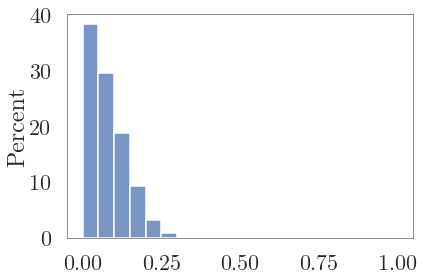

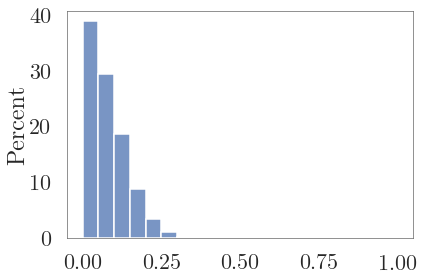

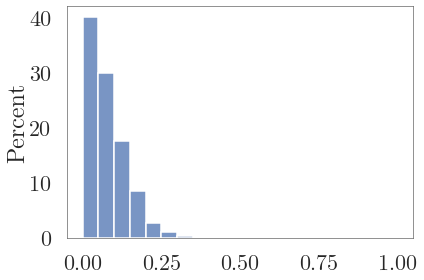

In [11]:
def measure_ssp_components(dim, turn_exp=1, coin_exp=1):
    sampler = nengo.dists.UniformHypersphere()
    def make_unitary(v):
        return v/np.absolute(v)
    turn_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
    coin_basis = make_unitary(np.fft.fft(sampler.sample(1, dim)))
    def encode_state(t, c):
        return np.fft.ifft(turn_basis**(t*turn_exp) * coin_basis**(c*coin_exp)).real.squeeze()
    components = []
    for t in range(6):
        for c in range(31):
            components.append(encode_state(t, c))
    components = np.ravel(np.abs(components))
    fig, ax = plt.subplots()
    sns.histplot(components, bins=20, stat="percent", ax=ax);
    plt.tight_layout()
    print(f"std: {np.std(components)}")

measure_ssp_components(100)
measure_ssp_components(100, turn_exp=2)
measure_ssp_components(100, coin_exp=0.1)

In [36]:
class NQ():

    class Environment():
        def __init__(self, dim, t1, t2, t3, rng, dt=1e-3):
            self.state = np.zeros((dim))
            self.rng = rng
            self.t1 = t1
            self.t2 = t2
            self.t3 = t3
            self.dt = dt
            self.replay = 0
            self.buffer = 0
        def set_state(self, state):
            self.state = state
        def get_state(self):
            return self.state
        def get_replay(self):
            return self.replay
        def get_buffer(self):
            return self.buffer
        
    def __init__(self, player, seed=0,
            n_neurons=5000, n_array=500, dim=100, sparsity=0.05, turn_exp=3, coin_exp=0.3,
            gate_mode="direct", memory_mode="direct", cleanup_mode=None,
            dt=1e-3, t1=1e-1, t2=1e-1, t3=1e-1, tR=1e-2):
        self.player = player
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        self.n_neurons = n_neurons
        self.n_array = n_array
        self.dt = dt
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self.tR = tR
        self.dim = dim
        self.memory_mode = memory_mode
        self.gate_mode = gate_mode
        self.cleanup_mode = cleanup_mode
        self.sparsity = sparsity
        self.turn_exp = turn_exp
        self.coin_exp = coin_exp
        self.sampler = nengo.dists.UniformHypersphere()
        self.turn_basis = self.make_unitary(np.fft.fft(self.sampler.sample(1, dim, rng=self.rng)))
        self.coin_basis = self.make_unitary(np.fft.fft(self.sampler.sample(1, dim, rng=self.rng)))
        self.intercept = nengo.dists.Choice([self.sparsity_to_x_intercept(dim, sparsity)])
        self.env = self.Environment(dim, t1, t2, t3, self.rng)
        self.encoders = self.find_good_encoders()
        self.network = self.build_network()
        self.simulator = nengo.Simulator(self.network, progress_bar=False)
        self.sM = np.zeros((dim))
        self.spikesM = np.zeros((n_neurons))
        self.simMRs = []
        self.sim01s = []
        self.mag0s  = []
        self.mag1s  = []
        self.uni01s = []
        self.qui01s = []
        self.uniMRs = []
        self.quiMRs = []

    def make_unitary(self, v):
        return v/np.absolute(v)

    def encode_state(self, t, c):
        return np.fft.ifft(self.turn_basis**(t*self.turn_exp) * self.coin_basis**(c*self.coin_exp)).real.squeeze()
    
    def sparsity_to_x_intercept(self, d, p):
        sign = 1
        if p > 0.5:
            p = 1.0 - p
            sign = -1
        return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))
    
    def find_good_encoders(self, iterations=10):
        
        class NodeInput():
            def __init__(self, dim):
                self.state = np.zeros((dim))
            def set_state(self, state):
                self.state = state
            def get_state(self):
                return self.state

        ssp_input = NodeInput(self.dim)
        encoders = self.sampler.sample(self.n_neurons, self.dim, rng=self.rng)
#         print("iteratively sampling encoders until neurons are active and unique")
        for i in range(iterations):
#             print(f"iteration {i}")
            network = nengo.Network(seed=self.seed)
            network.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
            network.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(300, 400)
            network.config[nengo.Probe].synapse = None
            with network:
                ssp_node = nengo.Node(lambda t, x: ssp_input.get_state(), size_in=2, size_out=self.dim)
                ens = nengo.Ensemble(self.n_neurons, self.dim, encoders=encoders, intercepts=self.intercept)
                nengo.Connection(ssp_node, ens, synapse=None, seed=self.seed)
                p_spikes = nengo.Probe(ens.neurons, synapse=None)
            sim = nengo.Simulator(network, progress_bar=False)

            spikes = []
            trials = []
            for turn in range(5):
                for coin in range(31):
                    trials.append([turn, coin])
                    sim.reset(self.seed)
                    ssp = self.encode_state(turn, coin)
                    ssp_input.set_state(ssp)
                    sim.run(0.001, progress_bar=False)
                    spk = sim.data[p_spikes][-1]
                    spikes.append(spk)
            spikes = np.array(spikes)
            inactives = list(np.where(np.sum(spikes, axis=0)==0)[0])

            non_uniques = []
            for pair in itertools.combinations(range(5*31), 2):
                spikes_a = spikes[pair[0]]
                spikes_b = spikes[pair[1]]
                for n in range(self.n_neurons):
                    s_a = spikes_a[n]
                    s_b = spikes_b[n]
                    if s_a>0 and s_b>0 and -1 < s_a-s_b < 1:
                        non_uniques.append(n)

            bad_neurons = np.sort(np.unique(inactives+non_uniques))
#             print(f"non unique neurons: {len(np.sort(np.unique(non_uniques)))}")
#             print(f"quiet neurons: {len(inactives)}")
#             print(f"non unique neurons: {np.sort(np.unique(non_uniques))}")
#             print(f"quiet neurons: {inactives}")
            if len(bad_neurons)==0:
                break

            new_encoders = self.sampler.sample(self.n_neurons, self.dim, rng=self.rng)
            for n in range(self.n_neurons):
                if n not in bad_neurons:
                    new_encoders[n] = encoders[n]
            encoders = np.array(new_encoders)
            
        return encoders

    def measure_sparsity(self, spikes1, spikes2):
        n_neurons = spikes1.shape[0]
        diff = []
        quiet = 0
        for n in range(n_neurons):
            if spikes1[n]+spikes2[n]>0:
                diff.append((spikes1[n]-spikes2[n]) / (spikes1[n]+spikes2[n]))
            else:
                quiet += 1
        diff = np.array(diff)
        quiet = quiet / n_neurons
        return diff, quiet

    def measure_similarity(self, ssp1, ssp2, mode="dot"):
        if mode=="dot":
            return np.sum(ssp1 * ssp2)
        elif mode=="cosine":
            return np.sum(ssp1 * ssp2) / (np.linalg.norm(ssp1, ord=2) * np.linalg.norm(ssp2, ord=2))

    def build_network(self):
        dim = self.dim
        n_neurons = self.n_neurons
        n_array = self.n_array
        seed = self.seed
        network = nengo.Network(seed=seed)
        network.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        network.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(300, 400)
        network.config[nengo.Probe].synapse = None
        with network:

            def StateGate(n_neurons, n_array, dim, seed, mode="direct"):
                net = nengo.Network(seed=seed)
                with net:
                    net.a = nengo.Node(size_in=dim)
                    net.b = nengo.Node(size_in=dim)
                    net.output = nengo.Node(size_in=dim)
                    if mode=="neuron":
                        wInh = -1e1*np.ones((n_neurons, 1))
                        net.gate_a = nengo.Ensemble(n_array, 1)
                        net.gate_b = nengo.Ensemble(n_array, 1)
                        net.ens_a = nengo.Ensemble(n_neurons, dim)
                        net.ens_b = nengo.Ensemble(n_neurons, dim)
                        nengo.Connection(net.a, net.ens_a, synapse=None)
                        nengo.Connection(net.b, net.ens_b, synapse=None)
                        nengo.Connection(net.ens_a, net.output, synapse=None)
                        nengo.Connection(net.ens_b, net.output, synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a.neurons, transform=wInh, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b.neurons, transform=wInh, synapse=None)
                    elif mode=="array":
                        wInh = -1e1*np.ones((n_array*dim, 1))
                        net.gate_a = nengo.Ensemble(n_array, 1)
                        net.gate_b = nengo.Ensemble(n_array, 1)
                        net.ens_a = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.ens_b = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.ens_a.add_neuron_input()
                        net.ens_b.add_neuron_input()
                        nengo.Connection(net.a, net.ens_a.input, synapse=None)
                        nengo.Connection(net.b, net.ens_b.input, synapse=None)
                        nengo.Connection(net.ens_a.output, net.output, synapse=None)
                        nengo.Connection(net.ens_b.output, net.output, synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a.neuron_input, transform=wInh, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b.neuron_input, transform=wInh, synapse=None)
                    elif mode=="direct":
                        net.gate_a = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.gate_b = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.ens_a = nengo.Ensemble(1, dim+1, neuron_type=nengo.Direct())
                        net.ens_b = nengo.Ensemble(1, dim+1, neuron_type=nengo.Direct())
                        nengo.Connection(net.a, net.ens_a[:-1], synapse=None)
                        nengo.Connection(net.b, net.ens_b[:-1], synapse=None)
                        nengo.Connection(net.gate_a, net.ens_a[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.gate_b, net.ens_b[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.ens_a, net.output, function=lambda x: x[:-1]*x[-1], synapse=None)
                        nengo.Connection(net.ens_b, net.output, function=lambda x: x[:-1]*x[-1], synapse=None)
                return net

            class GatedNode(nengo.Node):
                def __init__(self, dim):
                    self.dim = dim
                    self.size_in = dim + 1
                    self.size_out = dim
                    self.memory = np.zeros((dim))
                    super().__init__(self.step, size_in=self.size_in, size_out=self.size_out)
                def step(self, t, x):
                    ssp = x[:-1]
                    gate = int(x[-1])
                    if gate==1:
                        self.memory = ssp
                    return self.memory

            def StateGateMemory(n_neurons, n_array, dim, seed, n_gates=1, gain=0.1, synapse=0, mode="direct"):
                net = nengo.Network(seed=seed)
                with net:
                    net.state = nengo.Node(size_in=dim)
                    net.output = nengo.Node(size_in=dim)
                    if mode=="neuron":
                        wInh = -1e1*np.ones((n_neurons, 1))
                        net.gate = nengo.Node(size_in=1)
                        net.mem = nengo.Ensemble(n_neurons, dim)
                        net.diff = nengo.Ensemble(n_neurons, dim)
                        nengo.Connection(net.state, net.diff, synapse=None)
                        nengo.Connection(net.diff, net.mem, transform=gain, synapse=synapse)
                        nengo.Connection(net.mem, net.mem, synapse=synapse)
                        nengo.Connection(net.mem, net.diff, transform=-1, synapse=synapse)
                        nengo.Connection(net.gate, net.diff.neurons, transform=wInh, synapse=None)
                        nengo.Connection(net.mem, net.output, synapse=None)
                    elif mode=="array":
                        wInh = -1e1*np.ones((n_array*dim, 1))
                        net.gate = nengo.Node(size_in=1)
                        net.mem = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.diff = nengo.networks.EnsembleArray(n_array, dim, radius=0.3)
                        net.diff.add_neuron_input()
                        nengo.Connection(net.state, net.diff.input, synapse=None)
                        nengo.Connection(net.diff.output, net.mem.input, transform=gain, synapse=synapse)
                        nengo.Connection(net.mem.output, net.mem.input, synapse=synapse)
                        nengo.Connection(net.mem.output, net.diff.input, transform=-1, synapse=synapse)
                        nengo.Connection(net.gate, net.diff.neuron_input, transform=wInh, synapse=None)
                        nengo.Connection(net.mem.output, net.output, synapse=None)
                    elif mode=="direct":
                        net.gate = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
                        net.mem = GatedNode(dim)
                        nengo.Connection(net.state, net.mem[:-1], synapse=None)
                        nengo.Connection(net.gate, net.mem[-1], function=lambda x: 1-x, synapse=None)
                        nengo.Connection(net.mem, net.output, synapse=None)
                return net

            # inputs from environment
            state_input = nengo.Node(lambda t, x: self.env.get_state(), size_in=2, size_out=dim)
            replay_input = nengo.Node(lambda t, x: self.env.get_replay(), size_in=2, size_out=1)
            buffer_input = nengo.Node(lambda t, x: self.env.get_buffer(), size_in=2, size_out=1)

            state = nengo.Ensemble(n_neurons, dim, intercepts=self.intercept)
            state_memory = StateGateMemory(n_neurons, n_array, dim, seed, mode=self.memory_mode)
            state_gate = StateGate(n_neurons, n_array, dim, seed, mode=self.gate_mode)
            if self.cleanup_mode:
                state_cleanup = nengo.networks.AssociativeMemory(self.encoders, self.encoders, n_array)

            nengo.Connection(state_input, state_memory.state, synapse=None)
            nengo.Connection(buffer_input, state_memory.gate, function=lambda x: 1-x, synapse=None)
            nengo.Connection(state_input, state_gate.a, synapse=None)
            nengo.Connection(state_memory.output, state_gate.b, synapse=None)
            nengo.Connection(replay_input, state_gate.gate_a, synapse=None)
            nengo.Connection(replay_input, state_gate.gate_b, function=lambda x: 1-x, synapse=None)
            if self.cleanup_mode:
                nengo.Connection(state_gate.output, state_cleanup.input, synapse=None)
                nengo.Connection(state_cleanup.output, state, synapse=None)
            else:
                nengo.Connection(state_gate.output, state, synapse=None)

            network.p_state_input = nengo.Probe(state_input)
            network.p_state_memory = nengo.Probe(state_memory.output)
            network.p_state = nengo.Probe(state)
            network.p_spikes = nengo.Probe(state.neurons)

        return network

    def play(self):

        for turn in range(6):
            ssp_input = self.encode_state(turn, 10 if self.player=='investor' else self.rng.randint(0,31))
            self.env.set_state(ssp_input)
            self.env.buffer = 0
            self.env.replay = 0
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t1, progress_bar=False)
            state0 = self.simulator.data[self.network.p_state][-1]
            spikes0 = self.simulator.data[self.network.p_spikes][-1]
            mag0 = np.linalg.norm(state0, ord=2)
            self.mag0s.append(mag0)

            self.env.buffer = 0
            self.env.replay = 1
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t2, progress_bar=False)
            state1 = self.simulator.data[self.network.p_state][-1]
            spikes1 = self.simulator.data[self.network.p_spikes][-1]
            if turn>0:
                sim01 = self.measure_similarity(state0, state1)
                self.sim01s.append(sim01)
                simMR = self.measure_similarity(self.sM, state1)
                self.simMRs.append(simMR)
                mag1 = np.linalg.norm(state1, ord=2)
                self.mag1s.append(mag1)
                uniMR, quiMR = self.measure_sparsity(self.spikesM, spikes1)
                self.uniMRs.append(uniMR)
                self.quiMRs.append(quiMR)
            else:
                self.sim01s.append(None)
                self.simMRs.append(None)
                self.uniMRs.append([])
                self.quiMRs.append([])  
                self.mag1s.append(None)
            uni01, qui01 = self.measure_sparsity(spikes0, spikes1)
            self.uni01s.append(uni01)
            self.qui01s.append(qui01)
            
            self.env.buffer = 1
            self.env.replay = 0
            if self.tR>0: self.simulator.run(self.tR, progress_bar=False)
            self.simulator.run(self.t3, progress_bar=False)
            self.sM = self.simulator.data[self.network.p_state][-1]
            self.spikesM = self.simulator.data[self.network.p_spikes][-1]


In [37]:
def test_NQstates(n_neurons, n_array, dim, n_networks, player="investor",
        T=0.1, tR=0.01, turn_exp=1, coin_exp=1,
        gate_mode="direct", memory_mode="direct", cleanup_mode=None):
    columns = ("seed", "turn", "sim01", "simMR", "mag0", "mag1")
    dfs = []
    for n in range(n_networks):
        print(f"network {n}")
        net = NQ(player=player, seed=n, n_neurons=n_neurons, n_array=n_array, dim=dim,
                t1=T, t2=T, t3=T, tR=tR,
                turn_exp=turn_exp, coin_exp=coin_exp,
                gate_mode=gate_mode, memory_mode=memory_mode, cleanup_mode=cleanup_mode)
        start_time = time.time()
        net.play()
        end_time = time.time()
        print(f"execution time {end_time - start_time:.3}s")
        uni01s = []
        uniMRs = []
        for t in range(6):
            dfs.append(pd.DataFrame([[
                n, t, net.sim01s[t], net.simMRs[t], net.mag0s[t], net.mag1s[t]]],
                columns=columns))
            uni01s.extend(net.uni01s[t])
            uniMRs.extend(net.uniMRs[t])
    data = pd.concat(dfs, ignore_index=True)

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=((8,9)))
    sns.histplot(data['sim01'].to_numpy(), bins=20, stat="percent", ax=axes[0][0]);
    sns.histplot(data['simMR'].to_numpy(), bins=20, stat="percent", ax=axes[0][1]);
    sns.histplot(data['mag0'].to_numpy(), bins=20, stat="percent", ax=axes[1][0]);
    sns.histplot(data['mag1'].to_numpy(), bins=20, stat="percent", ax=axes[1][1]);
    sns.histplot(uni01s, bins=20, ax=axes[2][0]);
    sns.histplot(uniMRs, bins=20, ax=axes[2][1]);
    axes[0][0].set(title='sim01')
    axes[0][1].set(title='simMR')
    axes[1][0].set(title='mag0')
    axes[1][1].set(title='mag1')
    axes[2][0].set(title='uni01')
    axes[2][1].set(title='uniMR')
    plt.tight_layout()

network 0
execution time 1.27s
network 1
execution time 1.27s
network 2
execution time 1.34s
network 3
execution time 1.25s
network 4
execution time 1.25s
network 5
execution time 1.28s
network 6
execution time 1.27s
network 7
execution time 1.34s
network 8
execution time 1.25s
network 9
execution time 1.7s


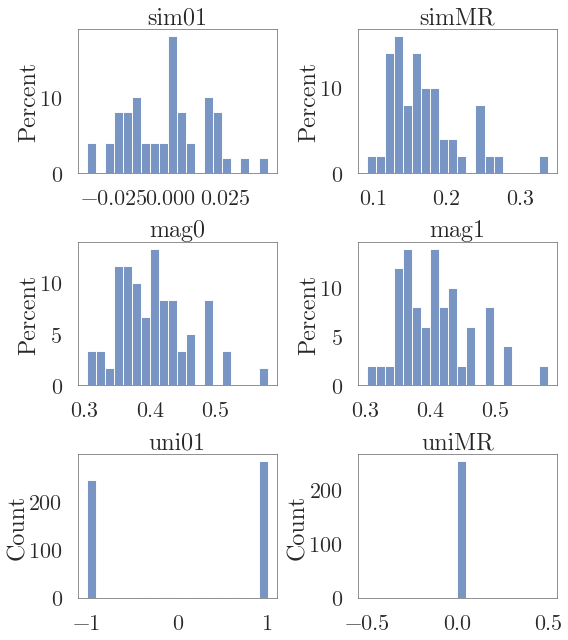

In [40]:
test_NQstates(1000, 0, 100, 10, turn_exp=3, coin_exp=0.3,
    gate_mode="direct", memory_mode="direct")

network 0
execution time 1.87s
network 1
execution time 2.06s
network 2
execution time 1.89s
network 3
execution time 2.12s
network 4
execution time 1.93s
network 5
execution time 1.86s
network 6
execution time 1.94s
network 7
execution time 1.8s
network 8
execution time 1.73s
network 9
execution time 1.77s
network 10
execution time 2.46s
network 11
execution time 1.74s
network 12
execution time 1.84s
network 13
execution time 2.11s
network 14


/home/pduggins/.local/share/virtualenvs/trust-game-Y0QYQoGm/lib/python3.7/site-packages/nengo/cache.py:610: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  "Decoder cache could not acquire lock and was "


execution time 4.65s
network 15
execution time 5.75s
network 16
execution time 3.34s
network 17
execution time 3.1s
network 18
execution time 3.27s
network 19
execution time 3.49s
network 20
execution time 3.89s
network 21
execution time 4.97s
network 22
execution time 3.31s
network 23
execution time 3.88s
network 24
execution time 3.09s
network 25
execution time 4.26s
network 26
execution time 3.64s
network 27
execution time 3.14s
network 28
execution time 3.69s
network 29
execution time 2.97s
network 30
execution time 4.06s
network 31
execution time 3.59s
network 32
execution time 3.55s
network 33
execution time 3.52s
network 34
execution time 2.67s
network 35
execution time 4.44s
network 36
execution time 3.04s
network 37
execution time 3.21s
network 38
execution time 3.63s
network 39
execution time 3.28s
network 40
execution time 3.69s
network 41
execution time 3.63s
network 42
execution time 3.3s
network 43
execution time 3.29s
network 44
execution time 3.06s
network 45
execution 

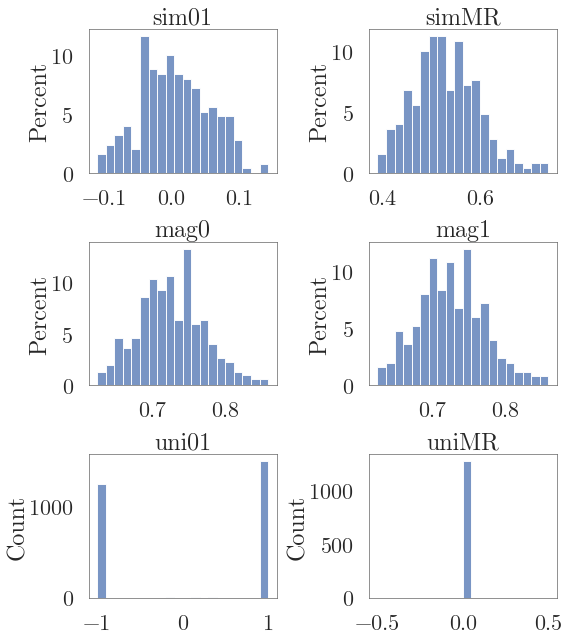

In [38]:
test_NQstates(5000, 0, 100, 50, turn_exp=3, coin_exp=0.3,
    gate_mode="direct", memory_mode="direct")

network 0
execution time 72.0s
network 1
execution time 70.9s


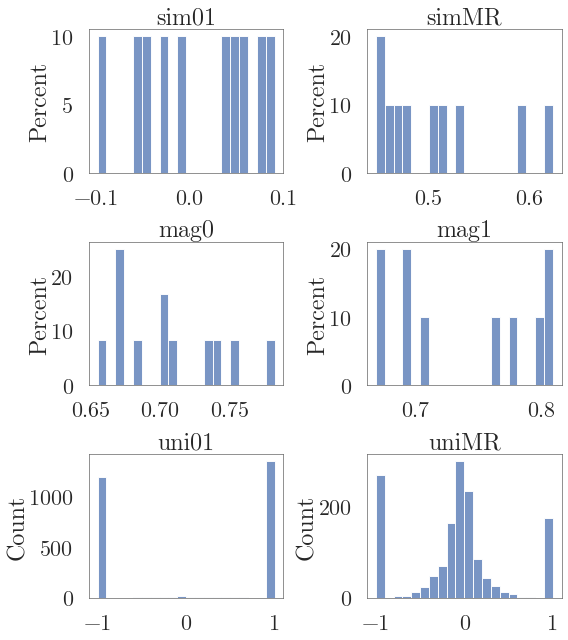

In [39]:
test_NQstates(5000, 500, 100, 2, turn_exp=3, coin_exp=0.3,
    gate_mode="array", memory_mode="array")

### before encoder search was implemented

network 0
execution time 1.87s
network 1
execution time 3.07s
network 2
execution time 2.29s
network 3
execution time 2.37s
network 4
execution time 2.13s
network 5
execution time 2.43s
network 6
execution time 2.1s
network 7
execution time 2.82s
network 8
execution time 3.55s
network 9
execution time 2.62s
network 10
execution time 2.5s
network 11
execution time 2.76s
network 12
execution time 2.3s
network 13
execution time 2.97s
network 14
execution time 3.25s
network 15
execution time 5.24s
network 16
execution time 4.32s
network 17
execution time 3.65s
network 18
execution time 4.94s
network 19
execution time 4.38s
network 20
execution time 3.5s
network 21
execution time 4.31s
network 22
execution time 4.43s
network 23
execution time 4.31s
network 24
execution time 5.12s
network 25
execution time 4.44s
network 26
execution time 4.79s
network 27
execution time 3.58s
network 28
execution time 3.42s
network 29
execution time 3.37s
network 30
execution time 4.13s
network 31
execution t

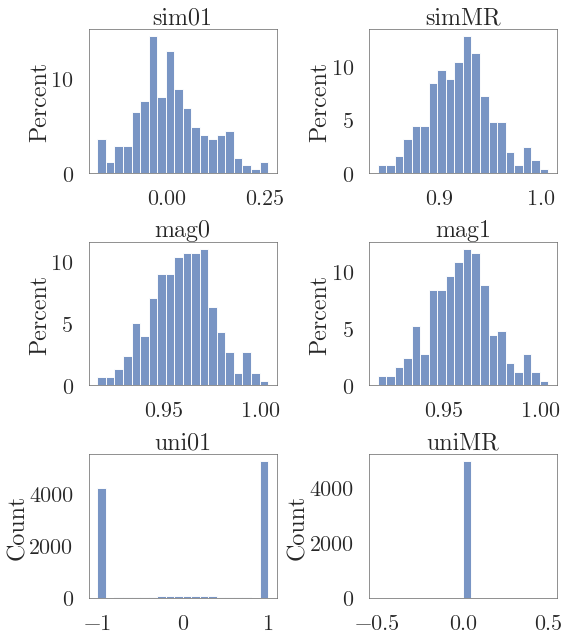

In [5]:
test_NQstates(5000, 500, 0.2, 100, 50, T=0.1, tR=0.01,
    turn_exp=3, coin_exp=0.1,
    gate_mode="direct", memory_mode="direct", cleanup_mode=None)

network 0
execution time 4.57s
network 1
execution time 4.97s
network 2
execution time 2.82s
network 3
execution time 2.3s
network 4
execution time 3.22s
network 5
execution time 4.14s
network 6
execution time 4.04s
network 7
execution time 3.49s
network 8
execution time 4.57s
network 9
execution time 4.21s
network 10
execution time 4.03s
network 11
execution time 2.56s
network 12
execution time 3.72s
network 13
execution time 3.45s
network 14
execution time 5.18s
network 15
execution time 5.41s
network 16
execution time 4.57s
network 17
execution time 4.02s
network 18
execution time 3.6s
network 19
execution time 4.76s
network 20
execution time 4.27s
network 21
execution time 4.32s
network 22
execution time 5.45s
network 23
execution time 3.55s
network 24
execution time 4.37s
network 25
execution time 2.87s
network 26
execution time 3.59s
network 27
execution time 4.02s
network 28
execution time 2.91s
network 29
execution time 3.02s
network 30
execution time 4.57s
network 31
execution

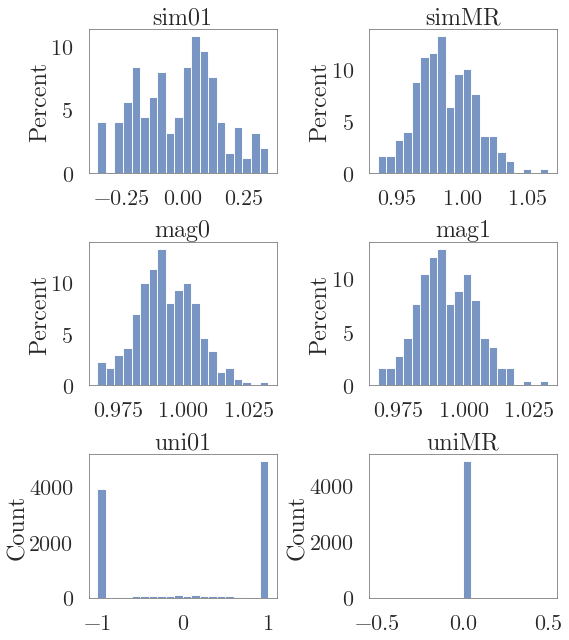

In [6]:
test_NQstates(5000, 500, 0.2, 50, 50, T=0.1, tR=0.01,
    turn_exp=3, coin_exp=0.3,
    gate_mode="direct", memory_mode="direct", cleanup_mode=None)

network 0
execution time 7.05s
network 1
execution time 6.81s
network 2
execution time 6.53s
network 3
execution time 5.72s
network 4
execution time 5.6s
network 5
execution time 7.1s
network 6
execution time 6.06s
network 7
execution time 5.14s
network 8
execution time 6.71s
network 9
execution time 5.82s
network 10
execution time 5.33s
network 11
execution time 6.67s
network 12
execution time 6.35s
network 13
execution time 6.09s
network 14
execution time 4.88s
network 15
execution time 6.52s
network 16
execution time 6.98s
network 17
execution time 5.28s
network 18
execution time 5.48s
network 19
execution time 7.8s
network 20
execution time 6.4s
network 21
execution time 5.43s
network 22
execution time 4.82s
network 23
execution time 6.65s
network 24
execution time 7.12s
network 25
execution time 5.57s
network 26
execution time 6.26s
network 27
execution time 6.69s
network 28
execution time 6.7s
network 29
execution time 5.72s
network 30
execution time 4.52s
network 31
execution ti

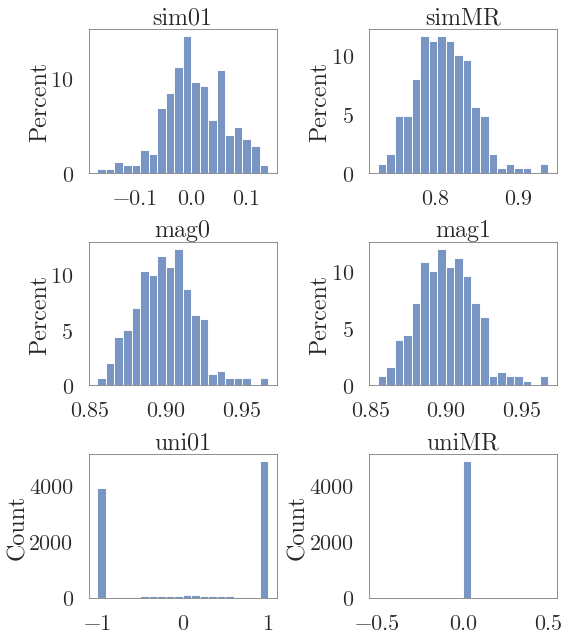

In [4]:
test_NQstates(5000, 500, 0.2, 200, 50, T=0.1, tR=0.01,
    turn_exp=3, coin_exp=0.3,
    gate_mode="direct", memory_mode="direct", cleanup_mode=None)

In [246]:
def FindGoodEncoders(n_neurons=1000, dim=100, sparsity=0.1, seeds=1, iterations=2,
        turn_exp=3, coin_exp=0.3):


    def make_unitary(v):
        return v/np.absolute(v)

    def encode_state(t, c, turn_basis, coin_basis, turn_exp, coin_exp):
        return np.fft.ifft(turn_basis**(t*turn_exp) * coin_basis**(c*coin_exp)).real.squeeze()
    
    def sparsity_to_x_intercept(d, p):
        sign = 1
        if p > 0.5:
            p = 1.0 - p
            sign = -1
        return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

    class NodeInput():
        def __init__(self, dim):
            self.state = np.zeros((dim))
        def set_state(self, state):
            self.state = state
        def get_state(self):
            return self.state

    for seed in range(seeds):
        print(f"seed {seed}")
        rng = np.random.RandomState(seed=seed)
        sampler = nengo.dists.UniformHypersphere()
        turn_basis = make_unitary(np.fft.fft(sampler.sample(1, dim, rng=rng)))
        coin_basis = make_unitary(np.fft.fft(sampler.sample(1, dim, rng=rng)))
        intercept = nengo.dists.Choice([sparsity_to_x_intercept(dim, sparsity)])
        ssp_input = NodeInput(dim)
        encoders = sampler.sample(n_neurons, dim, rng=rng)
        for i in range(iterations):
            network = nengo.Network(seed=seed)
            network.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
            network.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(300, 400)
            network.config[nengo.Probe].synapse = None
            with network:
                ssp_node = nengo.Node(lambda t, x: ssp_input.get_state(), size_in=2, size_out=dim)
                ens = nengo.Ensemble(n_neurons, dim, encoders=encoders, intercepts=intercept)
                nengo.Connection(ssp_node, ens, synapse=None, seed=seed)
                p_spikes = nengo.Probe(ens.neurons, synapse=None)
            sim = nengo.Simulator(network, progress_bar=False)

            spikes = []
            trials = []
            for turn in range(5):
                for coin in range(31):
                    trials.append([turn, coin])
                    sim.reset(seed)
                    ssp = encode_state(turn, coin, turn_basis, coin_basis, turn_exp, coin_exp)
                    ssp_input.set_state(ssp)
                    sim.run(0.001, progress_bar=False)
                    spk = sim.data[p_spikes][-1]
                    spikes.append(spk)
            spikes = np.array(spikes)
            inactives = list(np.where(np.sum(spikes, axis=0)==0)[0])

            non_uniques = []
            for pair in itertools.combinations(range(5*31), 2):
                spikes_a = spikes[pair[0]]
                spikes_b = spikes[pair[1]]
                for n in range(n_neurons):
                    s_a = spikes_a[n]
                    s_b = spikes_b[n]
                    if s_a>0 and s_b>0 and -1 < s_a-s_b < 1:
                        non_uniques.append(n)

            bad_neurons = np.sort(np.unique(inactives+non_uniques))
            print(f"non unique neurons: {np.sort(np.unique(non_uniques))}")
            print(f"quiet neurons: {inactives}")
            if len(bad_neurons)==0:
                break

            new_encoders = sampler.sample(n_neurons, dim, rng=rng)
            for n in range(n_neurons):
                if n not in bad_neurons:
                    new_encoders[n] = encoders[n]
            encoders = np.array(new_encoders)

In [248]:
FindGoodEncoders(n_neurons=100, dim=100, sparsity=0.05, seeds=1, iterations=20, turn_exp=3, coin_exp=0.3)

seed 0
non unique neurons: [ 0  1  5  8  9 11 13 14 16 17 18 25 26 29 31 33 35 45 46 51 56 66 69 70
 71 73 74 75 76 77 79 83 84 85 88 90 93 95 99]
quiet neurons: [39, 64, 65]
non unique neurons: [ 0  1 11 13 14 16 17 26 35 46 51 71 77 79 83 85]
quiet neurons: []
non unique neurons: [ 1 11 13 16 17 46 51 71 77 83]
quiet neurons: []
non unique neurons: [ 1 13 16 17 46 51 77]
quiet neurons: []
non unique neurons: [ 1 13 51]
quiet neurons: []
non unique neurons: [51]
quiet neurons: []
non unique neurons: [51]
quiet neurons: []
non unique neurons: []
quiet neurons: []
